In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download data

In [2]:
!curl -O "https://raw.githubusercontent.com/SaminRK/scPSS-reproducibility/refs/heads/master/data_downloaders/download_hlca_tutorial.py"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   927  100   927    0     0   1942      0 --:--:-- --:--:-- --:--:--  1939


In [3]:
from download_hlca_tutorial import download_hlca_tutorial
download_hlca_tutorial("data/")

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1wWGwbPeap-IqWNVlwVVUWVrUAMrf45ye
From (redirected): https://drive.google.com/uc?export=download&id=1wWGwbPeap-IqWNVlwVVUWVrUAMrf45ye&confirm=t&uuid=272f8383-d545-4d7c-9165-6ad60a271aa9
To: /content/hlca_tutorial.h5ad
100%|██████████| 118M/118M [00:01<00:00, 63.4MB/s]


## Use scPSS

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
!pip install git+https://github.com/SaminRK/scPSS.git

  Cloning https://github.com/SaminRK/scPSS.git to /tmp/pip-req-build-3s5w200l
  Running command git clone --filter=blob:none --quiet https://github.com/SaminRK/scPSS.git /tmp/pip-req-build-3s5w200l
  Resolved https://github.com/SaminRK/scPSS.git to commit c16c71713e6a618ed6196b83b1dc3daa30838e1a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of umap-learn to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 3.7 MB/s eta 0:00:00
  Created wheel for scPSS: fil

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
## Modify path according to where the file is located.
ad_total = sc.read('/content/data/hlca_tutorial.h5ad')

In [ ]:
ad_total

AnnData object with n_obs × n_vars = 450214 × 30
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'ann_level_1_label_final', 'ann_level_2_label_final', 'ann_level_3_label_final', 'ann_level_4_label_final', 'ann_level_5_label_final'
    obsm: 'X_umap'

## Problem scenario: healthy reference and diseased reference available

In [ ]:
DONOR_KEY = 'donor_id'

In [ ]:
ad_normal = ad_total[ad_total.obs['disease'] == 'normal']
ad_disease = ad_total[ad_total.obs['disease'] == 'pulmonary fibrosis']

normal_donor_ids = list(ad_normal.obs[DONOR_KEY].unique())
disease_donor_ids = list(ad_disease.obs[DONOR_KEY].unique())

In [ ]:
len(normal_donor_ids), len(disease_donor_ids)

(59, 52)

In [ ]:
def get_upper_limit(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    upper_limit = q3 + 1.5 * iqr
    upper_limit_from_data = q1
    for d in data:
        if d < upper_limit and d > upper_limit_from_data:
            upper_limit_from_data = d

    return upper_limit_from_data

In [ ]:
def plot_distance_distributions(dist_ref_ref, dist_que_ref, thres):
    import matplotlib.pyplot as plt

    plt.hist(dist_ref_ref, bins=100, alpha=.5, label='Reference-Reference')
    plt.hist(dist_que_ref, bins=100, alpha=.5, color='orange', label='Query-Reference')
    plt.axvline(thres, color='r', linestyle='--', label='threshold')
    plt.legend()
    plt.show()

In [ ]:
def plot_outlier_ratio_v_k(K_outlier_ratio_1, K_outlier_ratio_2, K_outlier_ratio_3, optimal_k):

    x_values, y_values = zip(*K_outlier_ratio_1)
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', alpha=.8, label='p-value cutoff=0.1')

    x_values, y_values = zip(*K_outlier_ratio_2)
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='r', alpha=.8, label='p-value cutoff=0.05')

    x_values, y_values = zip(*K_outlier_ratio_3)
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='grey', alpha=.8, label='p-value cutoff=0.01')

    plt.axvline(optimal_k, color='purple', linestyle='--', label='Optimal k')
    plt.xlabel('K')
    plt.ylabel('Outlier ratio')
    plt.legend(loc='lower right')

    # Show the plot
    plt.show()
    plt.close()

In [ ]:
def plot_outlier_ratio_v_p(q_outlier_ratio, optimal_p):

    x_values, y_values = zip(*q_outlier_ratio)
    x_values_ = [1 - x for x in x_values]

    plt.plot(x_values_, y_values, marker='o', linestyle='-', color='b')
    plt.axvline(optimal_p, color='r', linestyle='--', label='Optimal p-value cutoff')
    plt.legend()

    plt.xlabel('p-value cutoff')
    plt.ylabel('Outlier ratio')

    plt.show()
    plt.close()

In [ ]:
def get_middle_limit(ref_normal, ref_disease):
    lower = np.percentile(ref_normal, 75)
    upper = np.percentile(ref_disease, 25)
    mid = (2 * upper + lower) / 3
    limit = max(mid, lower)

    return limit

In [1]:
import gc
import random
import scanpy.external as sce
from scpss import scPSS


def process_celltype(ad, seed):
    gc.collect()
    random.seed(seed)

    ref_normal_num_donors = len(normal_donor_ids) * 1 // 2
    ref_disease_num_donors = len(disease_donor_ids) * 1 // 2
    ref_normal_donor_ids = random.sample(normal_donor_ids, ref_normal_num_donors)
    que_normal_donor_ids = [d for d in normal_donor_ids if d not in ref_normal_donor_ids]
    ref_disease_donor_ids = random.sample(disease_donor_ids, ref_disease_num_donors)
    que_disease_donor_ids = [d for d in disease_donor_ids if d not in ref_disease_donor_ids]

    ref_donor_ids = ref_normal_donor_ids + ref_disease_donor_ids
    que_donor_ids = que_normal_donor_ids + que_disease_donor_ids

    print(len(ref_normal_donor_ids), len(ref_disease_donor_ids), len(que_normal_donor_ids), len(que_disease_donor_ids))

    ad_scpss = ad[ad.obs[DONOR_KEY].isin(ref_donor_ids + que_donor_ids)]
    sc.tl.pca(ad_scpss)
    sce.pp.harmony_integrate(ad_scpss, key='sample')

    ref_normal_samples = ad_scpss[ad_scpss.obs[DONOR_KEY].isin(ref_normal_donor_ids)].obs['sample'].unique()
    ref_disease_samples = ad_scpss[ad_scpss.obs[DONOR_KEY].isin(ref_disease_donor_ids)].obs['sample'].unique()
    que_samples = ad_scpss[ad_scpss.obs[DONOR_KEY].isin(que_donor_ids)].obs['sample'].unique()

    ad_scpss_one = ad_scpss[ad_scpss.obs[DONOR_KEY].isin(ref_normal_donor_ids + ref_disease_donor_ids)]

    scpss = scPSS(ad_scpss_one, 'sample', ref_normal_samples, ref_disease_samples)
    scpss.find_optimal_parameters(search_n_comps=np.arange(4, 16), verbose=True)

    best_params = scpss.best_params
    scpss.set_distance_and_condition()


    outlier_ratio_ref_normal_datasets = []
    outlier_ratio_ref_disease_datasets = []

    from sklearn.neighbors import KNeighborsClassifier

    ad_ref_normal = scpss.adata[scpss.adata.obs[DONOR_KEY].isin(ref_normal_donor_ids)]
    ad_ref_diseased = scpss.adata[scpss.adata.obs[DONOR_KEY].isin(ref_disease_donor_ids)]

    X_ref_normal = ad_ref_normal.obsm['X_pca_harmony']
    X_ref_diseased = ad_ref_diseased.obsm['X_pca_harmony']

    X = np.vstack([X_ref_normal, X_ref_diseased])
    y_que = list(ad_ref_diseased.obs['scpss_outlier']  == 'Outlier')
    y = np.array([0] * len(X_ref_normal) + y_que)

    knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
    knn.fit(X, y)

    print(knn.score(X, y))

    ad_que = ad_scpss[ad_scpss.obs[DONOR_KEY].isin(que_donor_ids)]
    X_que = ad_que.obsm['X_pca_harmony']
    y_pred = knn.predict(X_que)

    outlier_ratio_in_que_normal = []
    outlier_ratio_in_que_diseased = []

    for donor in que_normal_donor_ids:
        y = y_pred[ad_que.obs[DONOR_KEY] == donor]
        if len(y) > 10: outlier_ratio_in_que_normal.append(np.mean(y))
        else: outlier_ratio_in_que_normal.append(None)

    for donor in que_disease_donor_ids:
        y = y_pred[ad_que.obs[DONOR_KEY] == donor]
        if len(y) > 10: outlier_ratio_in_que_diseased.append(np.mean(y))
        else: outlier_ratio_in_que_diseased.append(None)

    y_pred_ref_normal = knn.predict(X_ref_normal)
    y_pred_ref_diseased = knn.predict(X_ref_diseased)

    outlier_ratio_in_ref_normal = []
    outlier_ratio_in_ref_diseased = []

    for donor in ref_normal_donor_ids:
        y = y_pred_ref_normal[ad_ref_normal.obs[DONOR_KEY] == donor]
        if len(y) > 10: outlier_ratio_in_ref_normal.append(np.mean(y))
        else: outlier_ratio_in_ref_normal.append(None)

    for donor in ref_disease_donor_ids:
        y = y_pred_ref_diseased[ad_ref_diseased.obs[DONOR_KEY] == donor]
        if len(y) > 10: outlier_ratio_in_ref_diseased.append(np.mean(y))
        else: outlier_ratio_in_ref_diseased.append(None)

    def filter_none(lst):
        return [x for x in lst if x is not None]

    def replace_none(lst):
        return [x if x is not None else 0 for x in lst]

    Dict = {
        'Outlier Ratio in Ref Normal'  : filter_none(outlier_ratio_in_ref_normal),
        'Outlier Ratio in Ref Diseased': filter_none(outlier_ratio_in_ref_diseased),
        'Outlier Ratio in Que Normal'  : filter_none(outlier_ratio_in_que_normal),
        'Outlier Ratio in Que Diseased': filter_none(outlier_ratio_in_que_diseased),
    }

    outlier_ratio_threshold = get_middle_limit(
        filter_none(outlier_ratio_in_ref_normal),
        filter_none(outlier_ratio_in_ref_diseased),
    )

    fig, ax = plt.subplots(figsize=(4, 3))
    ax.boxplot(Dict.values())
    ax.set_xticklabels(Dict.keys())
    plt.axhline(outlier_ratio_threshold, color='r', linestyle='--', label='Middle Point')
    plt.xticks(rotation=45)
    plt.show()

    que_outlier_ratios = outlier_ratio_in_que_normal + outlier_ratio_in_que_diseased
    predicted_labels = np.array(replace_none(que_outlier_ratios)) > outlier_ratio_threshold
    true_labels = [0] * len(outlier_ratio_in_que_normal) + [1] * len(outlier_ratio_in_que_diseased)

    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    Dict = {
        'problem': f'problem-2-{celltype}',
        'ref_normal_samples': ref_normal_donor_ids,
        'ref_disease_samples': ref_disease_donor_ids,
        'que_normal_samples': que_normal_donor_ids,
        'que_disease_samples': que_disease_donor_ids,
        'ref_samples': ref_donor_ids,
        'que_samples': que_donor_ids,
        'accuracy': accuracy,
        'precision': precision,
        'f1': f1,
        'recall': recall,
        'outlier_ratio_in_ref_normal': outlier_ratio_in_ref_normal,
        'outlier_ratio_in_ref_diseased': outlier_ratio_in_ref_diseased,
        'outlier_ratio_in_que_normal': outlier_ratio_in_que_normal,
        'outlier_ratio_in_que_diseased': outlier_ratio_in_que_diseased,
    }

    return Dict

In [6]:
OUTPUT_PATH = "/content/drive/MyDrive/Research - Sohel sir/Pathological Cells/Pathological Cell Identification/reproducibility/scpss_data"

In [7]:
celltypes = [
    "Macrophages",
    "T cell lineage",
    "Secretory",
    "Multiciliated lineage",
    "Monocytes",
    "Lymphatic EC mature",
    "B cell lineage",
    "AT2",
    "Innate lymphoid cell NK",
    "EC arterial",
    "Basal",
    "EC venous",
    "Fibroblasts",
    "AT1",
    "Mast cells",
    "Myofibroblasts",
]

In [ ]:
import json
import os

for celltype in celltypes:
    print('Processing celltype:', celltype)
    os.makedirs(f"{OUTPUT_PATH}/scpss-problem-2", exist_ok=True)
    os.makedirs(f"{OUTPUT_PATH}/scpss-problem-2/{celltype}", exist_ok=True)

    ad = ad_total[ad_total.obs['ann_level_3_label_final'] == celltype]

    SAMPLE_SIZE = 100_000
    if len(ad) > SAMPLE_SIZE: sc.pp.subsample(ad, n_obs=SAMPLE_SIZE)

    for i in range(10):
        print('==>', i)
        seed = i * 100
        Dict = process_celltype(ad, seed)
        json.dump(Dict, open(f"{OUTPUT_PATH}/scpss-problem-2/{celltype}/{seed}.json", 'w'), indent=4)

## Integrate pathological scores of cells from each cell type to determine condition of individual

In [2]:
import json

In [3]:
PATH = "/content/drive/MyDrive/Research - Sohel sir/Pathological Cells/Pathological Cell Identification/reproducibility/scpss_data/scpss-problem-2"

In [4]:
celltypes = [
    "Macrophages",
    "T cell lineage",
    "Secretory",
    "Multiciliated lineage",
    "Monocytes",
    "Lymphatic EC mature",
    "B cell lineage",
    "AT2",
    "Innate lymphoid cell NK",
    "EC arterial",
    "Basal",
    "EC venous",
    "Fibroblasts",
    "AT1",
    "Mast cells",
    "Myofibroblasts",
]

In [5]:
my_dict = {}
for celltype in celltypes:
    dicts = []
    for i in range(10):
        fp = f"{PATH}/{celltype}/{i*100}.json"
        with open(fp, 'r') as file:
            data = json.load(file)
        dicts.append(data)
    accs = [d['accuracy'] for d in dicts]
    my_dict[celltype] = accs

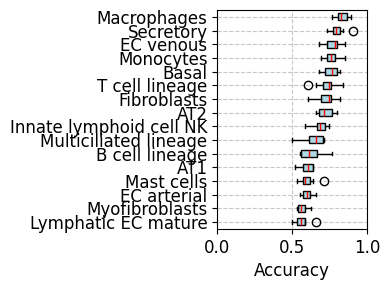

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Sort the dictionary by the mean of the values
sorted_dict = {k: v for k, v in sorted(my_dict.items(), key=lambda item: np.mean(item[1]))}

# Define figure size for better readability
fig, ax = plt.subplots(figsize=(4, 3))

# Create a horizontal box plot with sorted values
ax.boxplot(sorted_dict.values(), vert=False, patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='black'),
           whiskerprops=dict(color='black'),
           capprops=dict(color='black'),
           medianprops=dict(color='red'))

# Set y-axis labels with sorted keys
ax.set_yticklabels(sorted_dict.keys(), fontsize=12)

# Set x-axis label with larger font size
ax.set_xlabel('Accuracy', fontsize=12)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.7)

# Increase tick label size
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.xlim([0, 1])

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [7]:
for celltype in celltypes:
    print(celltype, np.median(sorted_dict[celltype]), np.mean(sorted_dict[celltype]))

Macrophages 0.8303571428571428 0.8339285714285714
T cell lineage 0.75 0.7392857142857142
Secretory 0.7946428571428572 0.8017857142857142
Multiciliated lineage 0.6607142857142857 0.6446428571428571
Monocytes 0.7589285714285714 0.7607142857142857
Lymphatic EC mature 0.5625 0.5625
B cell lineage 0.6160714285714286 0.6303571428571428
AT2 0.7142857142857143 0.7267857142857144
Innate lymphoid cell NK 0.6875 0.6857142857142857
EC arterial 0.5982142857142857 0.5999999999999999
Basal 0.7678571428571428 0.7571428571428571
EC venous 0.7857142857142857 0.7750000000000001
Fibroblasts 0.75 0.7303571428571428
AT1 0.6071428571428571 0.6035714285714285
Mast cells 0.5892857142857143 0.5999999999999999
Myofibroblasts 0.5625 0.5678571428571428


In [8]:
def get_upper_limit(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    upper_limit = q3 + 1.5 * iqr
    upper_limit_from_data = q1
    for d in data:
        if d < upper_limit and d > upper_limit_from_data:
            upper_limit_from_data = d

    return upper_limit_from_data

In [9]:
def average_labelling(diseased_portion, upper_limits):
    number = 0
    given_sum = 0
    limit_sum = 0
    for k, v in diseased_portion.items():
        if v is not None:
            number += 1
            given_sum += diseased_portion[k]
            limit_sum += upper_limits[k]

    return max(given_sum - limit_sum, 0) > .2

In [10]:
def average_labelling_score(diseased_portion, upper_limits):
    given_sum = 0
    limit_sum = 0
    for k, v in diseased_portion.items():
        if v is not None:
            given_sum += diseased_portion[k]
            limit_sum += upper_limits[k]
    return max(given_sum - limit_sum, 0)

In [11]:
def any_outlier_labelling(disease_portion, upper_limits):
    for k, v in disease_portion.items():
        if v is not None:
            if disease_portion[k] > upper_limits[k]:
                return True
    return False

In [12]:
def majority_labelling(disease_portion, upper_limits):
    outlier_vote = 0
    inlier_vote = 0
    for k, v in disease_portion.items():
        if v is not None:
            if disease_portion[k] > upper_limits[k]:
                outlier_vote += 1
            else:
                inlier_vote += 1
    return outlier_vote >= inlier_vote

In [13]:
def quick_labelling(disease_portion, upper_limits):
    outlier_vote = 0
    inlier_vote = 0
    for k, v in disease_portion.items():
        if v is not None:
            if disease_portion[k] > upper_limits[k]:
                outlier_vote += 1
            else:
                inlier_vote += 1
    return outlier_vote > 1

In [14]:
def priority_labelling(disease_portion, upper_limits):
    for celltype in ('Macrophages', 'EC venous', 'AT2'):
        if disease_portion[celltype] is not None:
            return disease_portion[celltype] > upper_limits[celltype]
    return False

In [15]:
def adjusted_average_labelling(disease_portion, upper_limits, inlier_weight=0.15, threshold=0.15):
    number = 0
    given_sum = 0
    limit_sum = 0
    for k, v in disease_portion.items():
        if v is not None:
            number += 1
            if disease_portion[k] >= upper_limits[k]:
                given_sum += (1 - inlier_weight) * (disease_portion[k] - upper_limits[k]) / (1 - upper_limits[k])
            else:
                given_sum += inlier_weight * (disease_portion[k] - upper_limits[k]) / upper_limits[k]
    return number != 0 and given_sum > threshold

In [16]:
def adjusted_average_labelling_score(disease_portion, upper_limits, inlier_weight=.2):
    number = 0
    given_sum = 0
    limit_sum = 0
    for k, v in disease_portion.items():
        if v is not None:
            number += 1
            if disease_portion[k] > upper_limits[k]:
                given_sum += (1 - inlier_weight) * (disease_portion[k] - upper_limits[k]) / (1 - upper_limits[k])
            else:
                given_sum += inlier_weight * (disease_portion[k] - upper_limits[k]) / upper_limits[k]
    return given_sum

## All combos

In [17]:
celltypes = [
    'Macrophages',
    'Secretory',
    'Basal',
    'Monocytes',
    'EC venous',
]

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def get_acc_for_test_id(id=0, labelling_fn=quick_labelling, verbose=False):
    dict_of_dicts = {}

    for celltype in celltypes:
        dict_of_dicts[celltype] = json.loads(open(f"{PATH}/{celltype}/{id*100}.json", 'r').read())

    Dict = dict_of_dicts['Macrophages']
    que_samples = Dict['que_samples']
    que_normal_samples = Dict['que_normal_samples']
    que_disease_samples = Dict['que_disease_samples']

    true_labels = [0] * len(que_normal_samples) + [1] * len(que_disease_samples)

    upper_limits = {}

    def filter_nones(l):
        return [x for x in l if x is not None]

    for celltype in celltypes:
        upper_limits[celltype] = get_upper_limit(filter_nones(dict_of_dicts[celltype]['outlier_ratio_in_ref_normal']))

    label = []
    for i, que_disease in enumerate(Dict['que_normal_samples']):
        disease_portion = {}
        for celltype in celltypes:
            disease_portion[celltype] = dict_of_dicts[celltype]['outlier_ratio_in_que_normal'][i]
        label.append(labelling_fn(disease_portion, upper_limits))

    for i, que_disease in enumerate(Dict['que_disease_samples']):
        disease_portion = {}
        for celltype in celltypes:
            disease_portion[celltype] = dict_of_dicts[celltype]['outlier_ratio_in_que_diseased'][i]
        label.append(labelling_fn(disease_portion, upper_limits))

    predicted_labels = label
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    if verbose:
        print(id, accuracy, precision, recall, f1)

    return accuracy, precision, recall, f1, predicted_labels

In [19]:
labelling_algos = {
    'Quick': quick_labelling,
    # 'Priority': priority_labelling,
    'Majority': majority_labelling,
    'Any': any_outlier_labelling,
    'Average': average_labelling,
    'Adjusted Average 0.30': lambda disease_portion, upper_limits: adjusted_average_labelling(disease_portion, upper_limits, inlier_weight=0.3),
    'Adjusted Average 0.25': lambda disease_portion, upper_limits: adjusted_average_labelling(disease_portion, upper_limits, inlier_weight=0.25),
    'Adjusted Average 0.20': lambda disease_portion, upper_limits: adjusted_average_labelling(disease_portion, upper_limits, inlier_weight=0.2),
    'Adjusted Average 0.15': lambda disease_portion, upper_limits: adjusted_average_labelling(disease_portion, upper_limits, inlier_weight=0.15),
    'Adjusted Average 0.10': lambda disease_portion, upper_limits: adjusted_average_labelling(disease_portion, upper_limits, inlier_weight=0.1),
    'Adjusted Average 0.05': lambda disease_portion, upper_limits: adjusted_average_labelling(disease_portion, upper_limits, inlier_weight=0.05),
    'Adjusted Average 0.03': lambda disease_portion, upper_limits: adjusted_average_labelling(disease_portion, upper_limits, inlier_weight=0.03),
    'Adjusted Average 0.02': lambda disease_portion, upper_limits: adjusted_average_labelling(disease_portion, upper_limits, inlier_weight=0.02),
}

In [20]:
accuracies = {}
precisions = {}
recalls = {}
f1s = {}
predicts = {}

for name, labelling_fn in labelling_algos.items():
    accs, pres, recs, fs, pls = [], [], [], [], []
    for i in range(10):
        accuracy, precision, recall, f1, pl = get_acc_for_test_id(i, labelling_fn)
        accs.append(accuracy)
        pres.append(precision)
        recs.append(recall)
        fs.append(f1)
        pls.append(np.mean(pl))

    accuracies[name] = accs
    precisions[name] = pres
    recalls[name] = recs
    f1s[name] = fs
    predicts[name] = pls

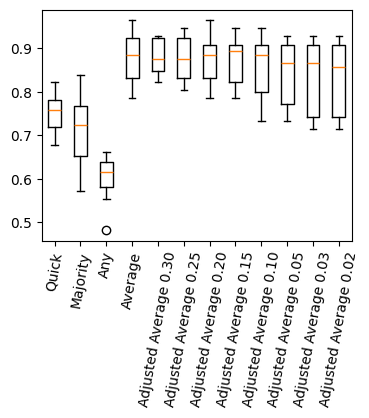

In [21]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.boxplot(accuracies.values())
ax.set_xticklabels(accuracies.keys())
plt.xticks(rotation=80)
plt.show()

In [22]:
for name, acc in accuracies.items():
    print(name, np.median(acc), np.mean(acc))

Quick 0.7589285714285714 0.7500000000000001
Majority 0.7232142857142858 0.7107142857142857
Any 0.6160714285714286 0.6035714285714285
Average 0.8839285714285714 0.8785714285714287
Adjusted Average 0.30 0.875 0.8803571428571428
Adjusted Average 0.25 0.875 0.8767857142857144
Adjusted Average 0.20 0.8839285714285714 0.875
Adjusted Average 0.15 0.8928571428571429 0.8696428571428573
Adjusted Average 0.10 0.8839285714285714 0.8571428571428573
Adjusted Average 0.05 0.8660714285714286 0.8410714285714287
Adjusted Average 0.03 0.8660714285714286 0.8339285714285714
Adjusted Average 0.02 0.8571428571428572 0.8321428571428571


In [23]:
my_dict = {}
for celltype in celltypes:
    dicts = []
    for i in range(10):
        fp = f"{PATH}/{celltype}/{i*100}.json"
        with open(fp, 'r') as file:
            data = json.load(file)
        dicts.append(data)
    accs = [d['accuracy'] for d in dicts]
    my_dict[celltype] = accs

sorted_dict = {k: v for k, v in sorted(my_dict.items(), key=lambda item: np.mean(item[1]))}

In [24]:
print_dict_comb = {}

for name, acc in sorted_dict.items():
    print_dict_comb[name] = acc

print_dict_comb['All'] = accuracies['Average']

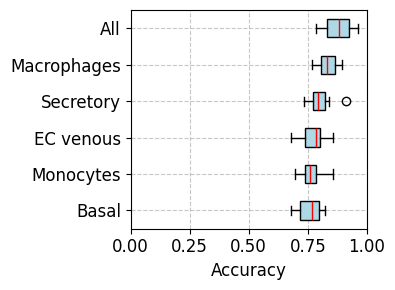

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Sort the dictionary by the mean of the values
sorted_dict = {k: v for k, v in sorted(print_dict_comb.items(), key=lambda item: np.mean(item[1]))}

# Define figure size for better readability
fig, ax = plt.subplots(figsize=(4, 3))

# Create a horizontal box plot with sorted values
ax.boxplot(print_dict_comb.values(), vert=False, patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='black'),
           whiskerprops=dict(color='black'),
           capprops=dict(color='black'),
           medianprops=dict(color='red'))

# Set y-axis labels with sorted keys
ax.set_yticklabels(print_dict_comb.keys(), fontsize=12)

# Set x-axis label with larger font size
ax.set_xlabel('Accuracy', fontsize=12)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.7)

# Increase tick label size
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.xlim([0, 1])

# Tight layout for better spacing
plt.tight_layout()

plt.savefig('accuracy_supervised.svg')

# Show the plot
plt.show()
